# Visualize time series samples from healthcare dataset

*Suiyi Liu, 2023.7.10*

- read dataset: transform patient record into standard time series form
- visualize the observed data in certain sample record
- visualize a certain attribute in a butch of patient records
- missing ratio of one attribute in different hours
- correlations of missing pattern between attributes
- time series normailization: z-score standard
- correlations of observed values in different attributes

*Note: limited to capicity of personal computer, only a small sample is chosen from complete dataset for demonstration*


## read patient records

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re
import os,sys
import warnings
import seaborn as sns

os.chdir(sys.path[0])
warnings.filterwarnings("ignore")
rc("font",family="MicroSoft YaHei",weight="bold") #chinese display in plot labels

In [3]:
# known info about attributes and timespan
attr_count=35
hour_count=48

# 35 attributes which contains enough non-values
attributes = ['DiasABP', 'HR', 'Na', 'Lactate', 'NIDiasABP', 'PaO2', 'WBC', 'pH', 'Albumin', 'ALT', 'Glucose', 'SaO2',
              'Temp', 'AST', 'Bilirubin', 'HCO3', 'BUN', 'RespRate', 'Mg', 'HCT', 'SysABP', 'FiO2', 'K', 'GCS',
              'Cholesterol', 'NISysABP', 'TroponinT', 'MAP', 'TroponinI', 'PaCO2', 'Platelets', 'Urine', 'NIMAP',
              'Creatinine', 'ALP']

def extract_hour(x)->int:
    """convert string type index into int type"""
    h, _ = map(int, x.split(":"))
    return h

def parse_data(x)->list[float]:
    """extract the last value for each attribute"""
    x = x.set_index("Parameter").to_dict()["Value"]
    values = []

    for attr in attributes:
        if x.__contains__(attr):
            values.append(x[attr])
        else:
            values.append(np.nan)
    return values

def read_record(path:str)->pd.DataFrame:
    dataset_raw=pd.read_csv(path)
    dataset_raw["Time"]=dataset_raw["Time"].apply(lambda x: extract_hour(x))

    _list:list[list[float]]=[]
    for h in range(48):
        _list.append(parse_data(dataset_raw[dataset_raw["Time"] == h]))
    dataset=pd.DataFrame(_list,columns=attributes)
    return dataset


## take a glance at certain one patient record

In [4]:
"""take a glance at certain one patient record, no normalization cast"""
dataset=read_record("./sample_data.csv")
dataset_valid=dataset.dropna(how="all",axis=1)
dataset_valid.head()

,HR,Na,NIDiasABP,WBC,Glucose,Temp,HCO3,BUN,RespRate,Mg,HCT,K,GCS,NISysABP,Platelets,Urine,NIMAP,Creatinine
0,77.0,NaN,58.0,NaN,NaN,35.6,NaN,NaN,19.0,NaN,NaN,NaN,15.0,157.0,NaN,60.0,91.00,NaN
1,60.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,137.0,NaN,30.0,87.00,NaN
2,62.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,123.0,NaN,170.0,75.67,NaN
3,80.0,NaN,52.0,NaN,NaN,37.8,NaN,NaN,20.0,NaN,33.7,NaN,15.0,114.0,NaN,60.0,72.67,NaN
4,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


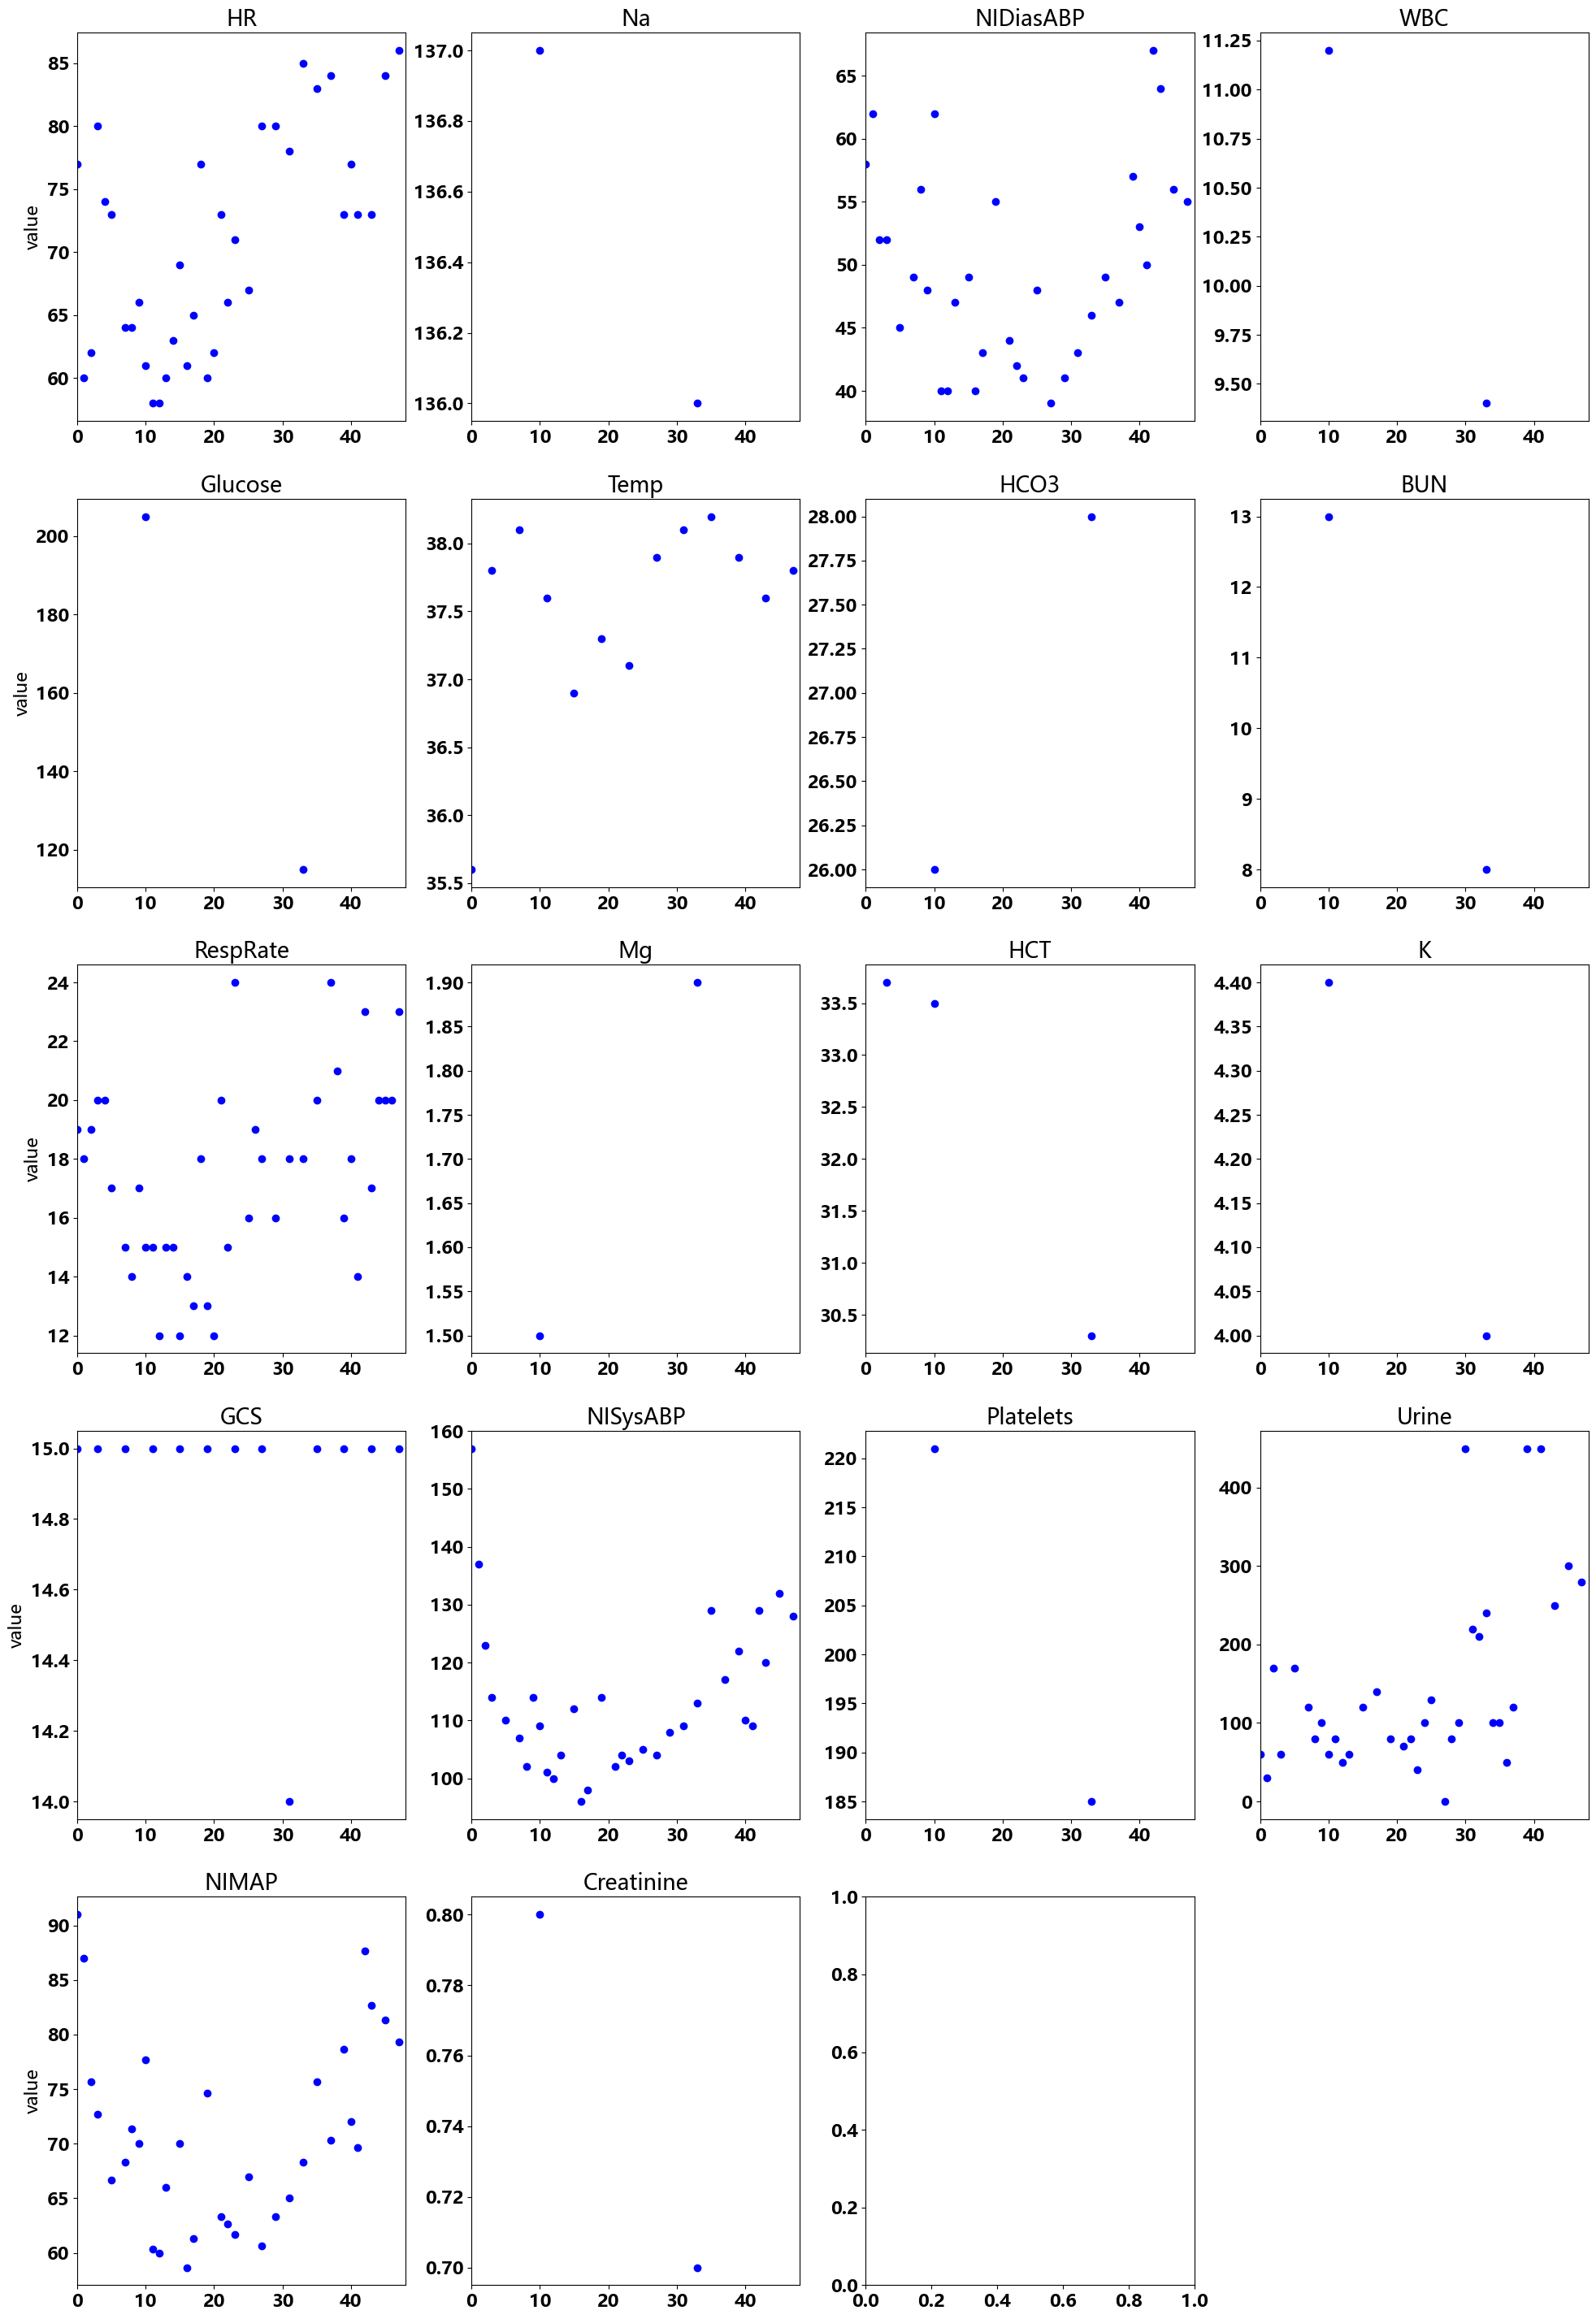

In [5]:

plt.rcParams["font.size"] = 16
L,K=dataset_valid.shape

fig, axes = plt.subplots(nrows=int(np.ceil(K/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,attr in zip(range(K),dataset_valid.columns):
    df=pd.DataFrame({"x":np.arange(0,L),"val":dataset_valid[attr]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].set_xlim((0,L))
    axes[row][col].set_title(attr)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
#plt.suptitle("observed values in sample data")
plt.show()
    

## take a glance at certain one attribute in butch of records

In [6]:
"""read a butch of patient records (maybe all of, but personal computer cannot carry that way)"""

def get_idlist()->list:
    """get patient id from file names in 6 digital form and sort"""
    patient_id = []
    for filename in os.listdir("../data/physio/set-a"):
        match = re.search(r"\d{6}", filename) 
        if match:
            patient_id.append(match.group())
    patient_id = np.sort(patient_id)
    return patient_id.tolist()

def read_dataset_tolist(count:int=100)->tuple[list[pd.DataFrame],list[str]]:
    id_list=get_idlist() #full record count : 4000
    id_list=id_list[0:count] # for a preview
    dataset_list:list[pd.DataFrame]=[]
    for _id in id_list:
        try:
            dataset=read_record("../data/physio/set-a/{}.txt".format(_id))
            dataset_list.append(dataset)
        except IOError as e:
            print(_id,e)
            continue
    return dataset_list,id_list

def read_dataset_toDF(count:int)->pd.DataFrame:
    id_list=get_idlist() #full record count : 4000
    id_list=id_list[0:count] # for a preview
    dataset_df=pd.DataFrame(columns=attributes,index=id_list)
    for _id in id_list:
        try:
            dataset=read_record("../data/physio/set-a/{}.txt".format(_id))
            _array=np.array(dataset.values).transpose().tolist()
            _list=[_array]
            dataset_df.loc[[_id]]=_list
        except IOError as e:
            print(_id,e)
            continue
    return dataset_df


In [7]:
"""take a glance at certain one attribute in butch of records, no normalization cast"""
dataset_list,id_list=read_dataset_tolist(count=50)
target_attr="NIDiasABP"

In [8]:
attr_df=pd.DataFrame(columns=id_list)
for k in range(0,len(id_list)):
    _id=id_list[k]
    _values=dataset_list[k][target_attr]
    attr_df[_id]=_values
attr_df=attr_df.dropna(how="all",axis=1)
attr_df.head()

,132539,132540,132541,132543,132545,132547,132548,132551,132554,132555,...,132618,132622,132623,132632,132634,132635,132636,132639,132642,132650
0,58.0,NaN,83.0,69.0,NaN,NaN,79.0,NaN,NaN,NaN,...,47.0,NaN,NaN,82.0,39.0,NaN,53.0,NaN,71.0,91.0
1,62.0,NaN,89.0,63.0,NaN,NaN,76.0,NaN,NaN,NaN,...,55.0,68.0,NaN,45.0,43.0,NaN,53.0,NaN,80.0,68.0
2,52.0,NaN,82.0,74.0,50.0,NaN,77.0,NaN,NaN,NaN,...,48.0,49.0,NaN,66.0,44.0,NaN,51.0,NaN,86.0,62.0
3,52.0,NaN,75.0,70.0,29.0,NaN,NaN,NaN,71.0,NaN,...,53.0,64.0,NaN,58.0,NaN,NaN,53.0,NaN,71.0,68.0
4,NaN,NaN,72.0,68.0,44.0,89.0,NaN,NaN,71.0,NaN,...,57.0,38.0,NaN,49.0,NaN,NaN,35.0,NaN,91.0,48.0


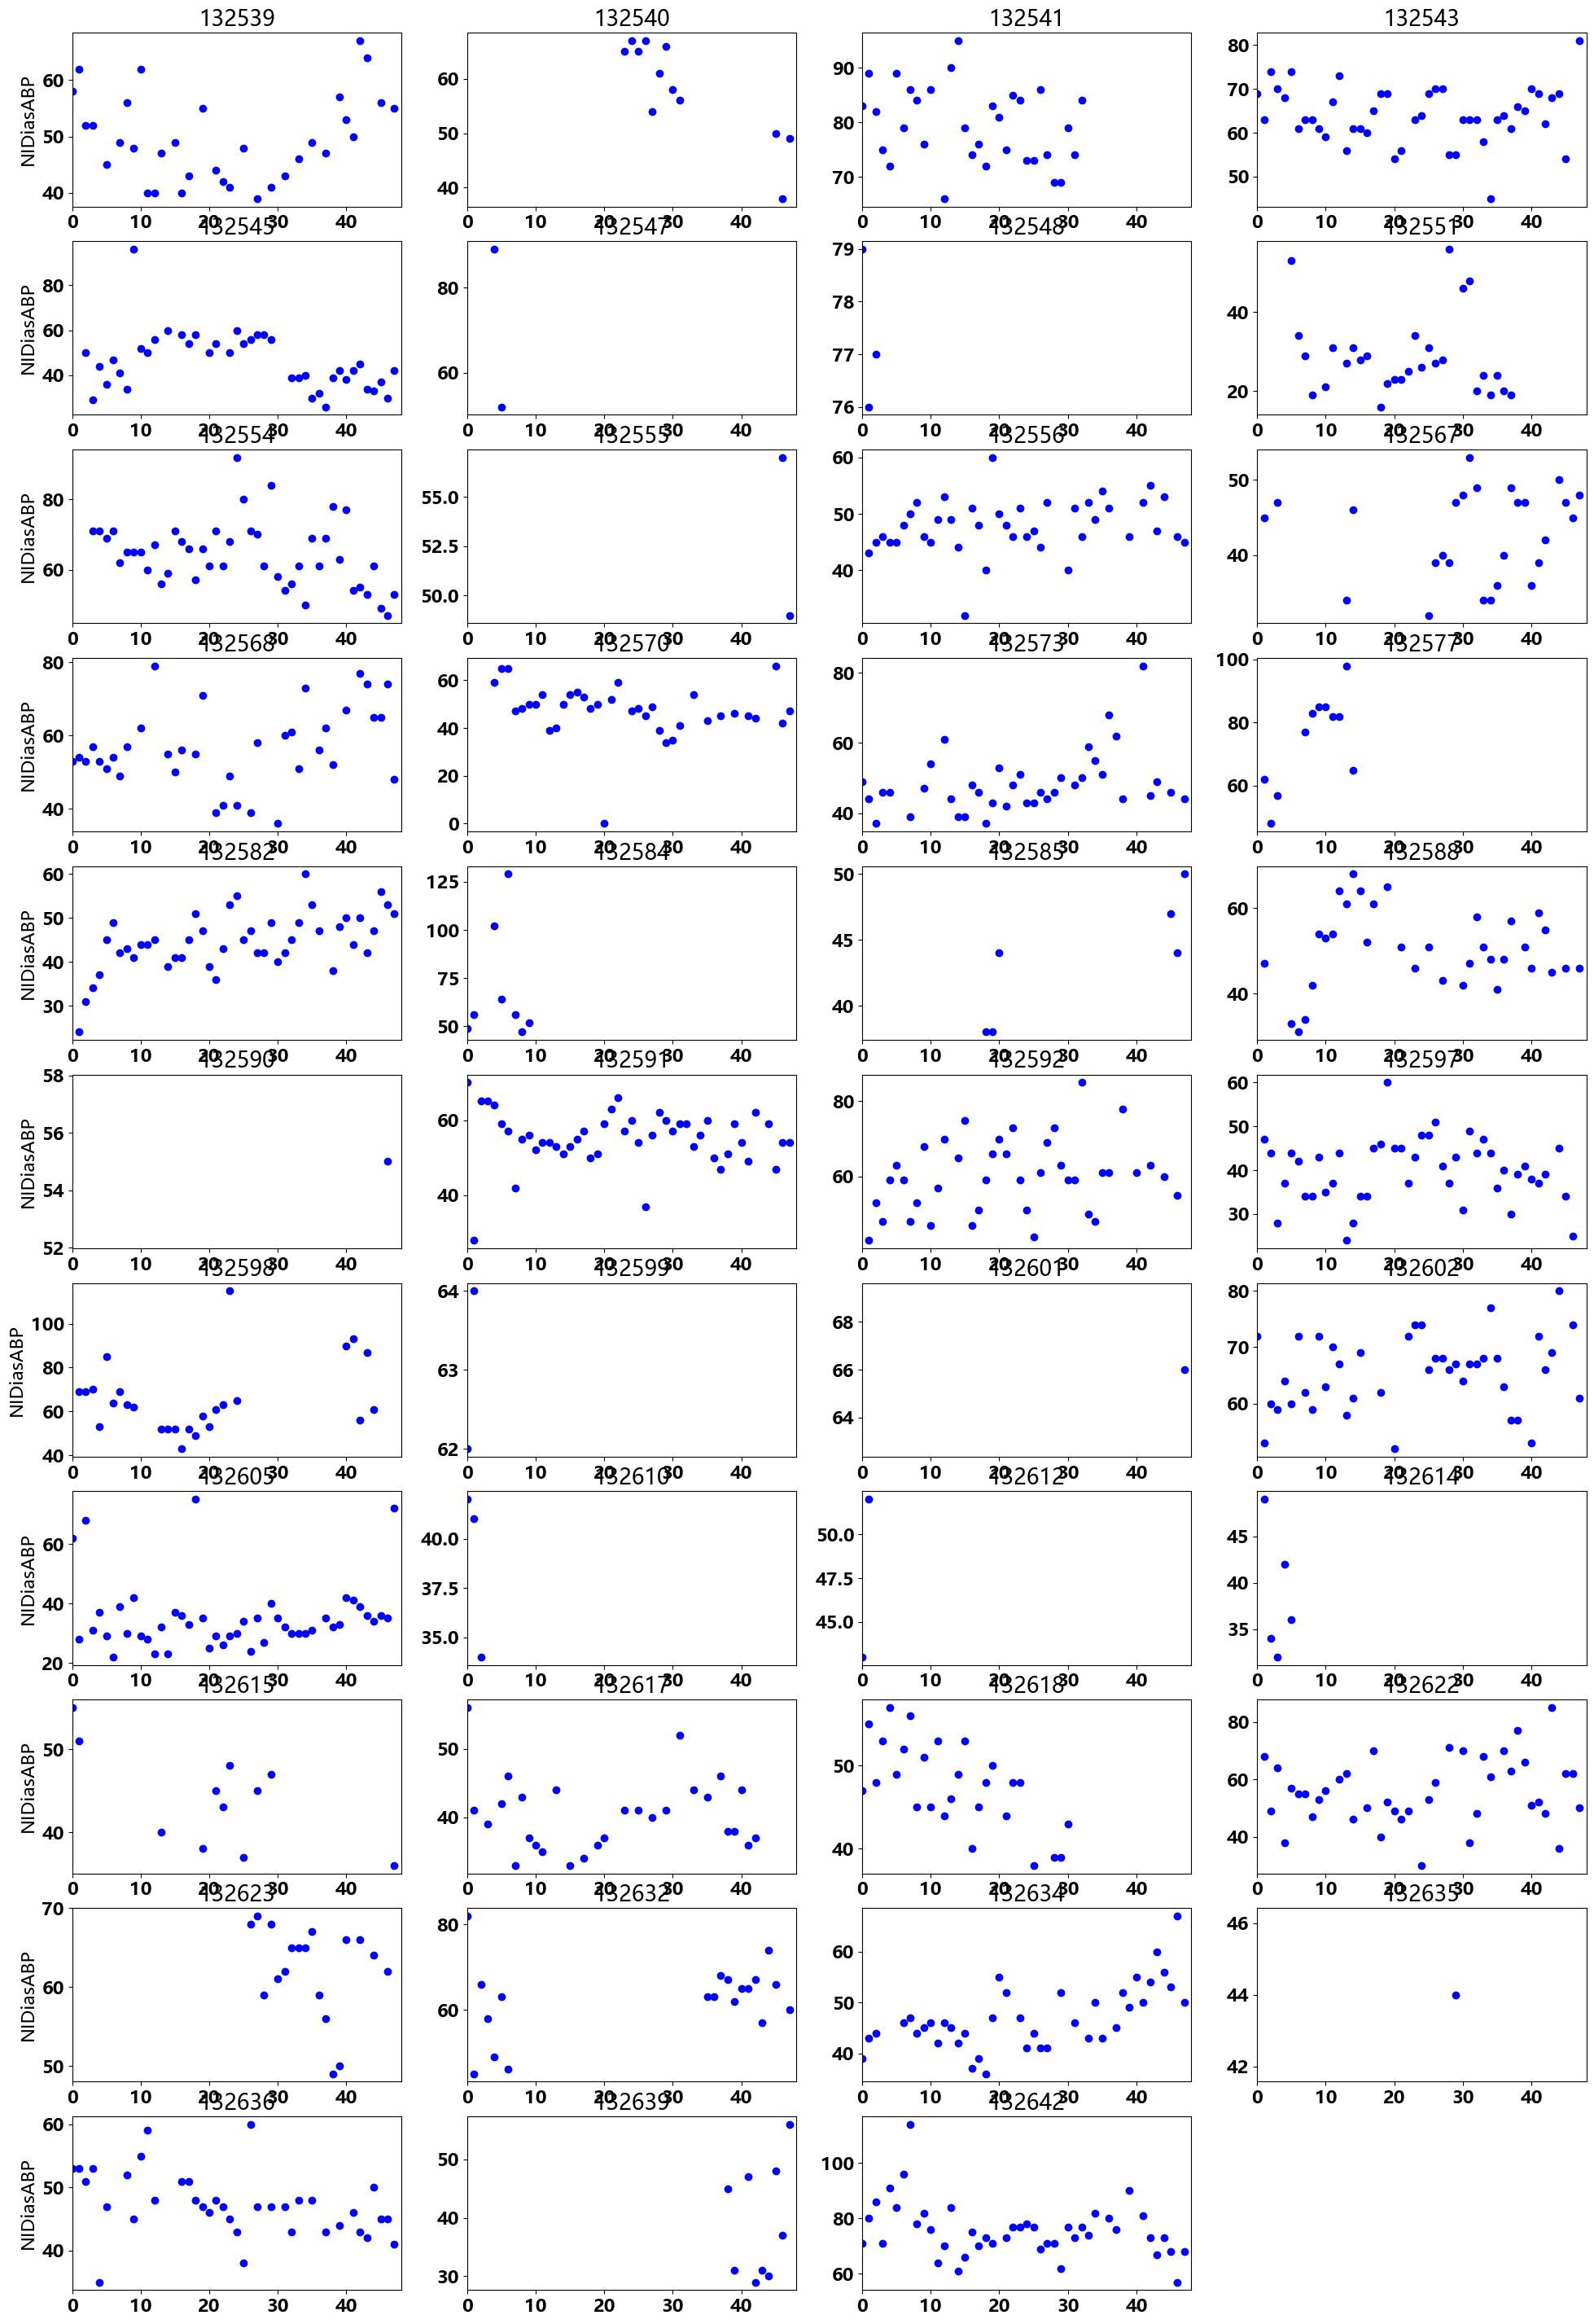

In [9]:

plt.rcParams["font.size"] = 16
L,K=attr_df.shape

fig, axes = plt.subplots(nrows=int(np.ceil(K/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,_id in zip(range(K),attr_df.columns):
    df=pd.DataFrame({"x":np.arange(0,L),"val":attr_df[_id]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].set_xlim((0,L))
    axes[row][col].set_title(_id)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel=target_attr)
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
plt.show()

## missing ratio in timespan of attributes

In [13]:
df_all=read_dataset_toDF(count=100)
df_all=df_all.applymap(lambda x:np.array(x))
df_all.head(n=1)

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[77.0, 60.0, 62.0, 80.0, 74.0, 73.0, nan, 64.0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[58.0, 62.0, 52.0, 52.0, nan, 45.0, nan, 49.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[157.0, 137.0, 123.0, 114.0, nan, 110.0, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[60.0, 30.0, 170.0, 60.0, nan, 170.0, nan, 120...","[91.0, 87.0, 75.67, 72.67, nan, 66.67, nan, 68...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [14]:
df_missVal=df_all.applymap(lambda x:np.isnan(x))
df_missVal.head(n=1)

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, True, False, True...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",...,"[False, False, False, False, True, False, True...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, True, False, True...","[False, False, False, False, True, False, True...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru..."


In [15]:
df_missRatio=pd.DataFrame(columns=attributes)
_df=df_missVal.applymap(lambda x:np.array(x,dtype=int))
for attr in attributes:
    _values=np.array(_df[attr],dtype=np.ndarray)
    df_missRatio[attr]=_values.sum()/df_missVal.shape[0]

df_missRatio.head()

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
0,0.81,0.47,0.88,0.94,0.59,0.82,0.88,0.81,0.94,0.93,...,0.59,0.99,0.81,0.99,0.81,0.87,0.72,0.59,0.87,0.93
1,0.66,0.23,0.85,0.91,0.41,0.80,0.82,0.80,0.94,0.93,...,0.41,0.97,0.66,0.99,0.81,0.80,0.43,0.41,0.81,0.93
2,0.59,0.18,0.90,0.91,0.48,0.78,0.91,0.76,0.97,0.97,...,0.48,0.98,0.59,1.00,0.77,0.89,0.33,0.48,0.89,0.97
3,0.55,0.16,0.88,0.91,0.51,0.80,0.91,0.80,0.96,0.95,...,0.51,0.99,0.55,0.97,0.80,0.89,0.36,0.52,0.89,0.95
4,0.52,0.13,0.90,0.93,0.51,0.77,0.91,0.77,0.98,0.97,...,0.51,1.00,0.54,1.00,0.77,0.89,0.41,0.51,0.87,0.97


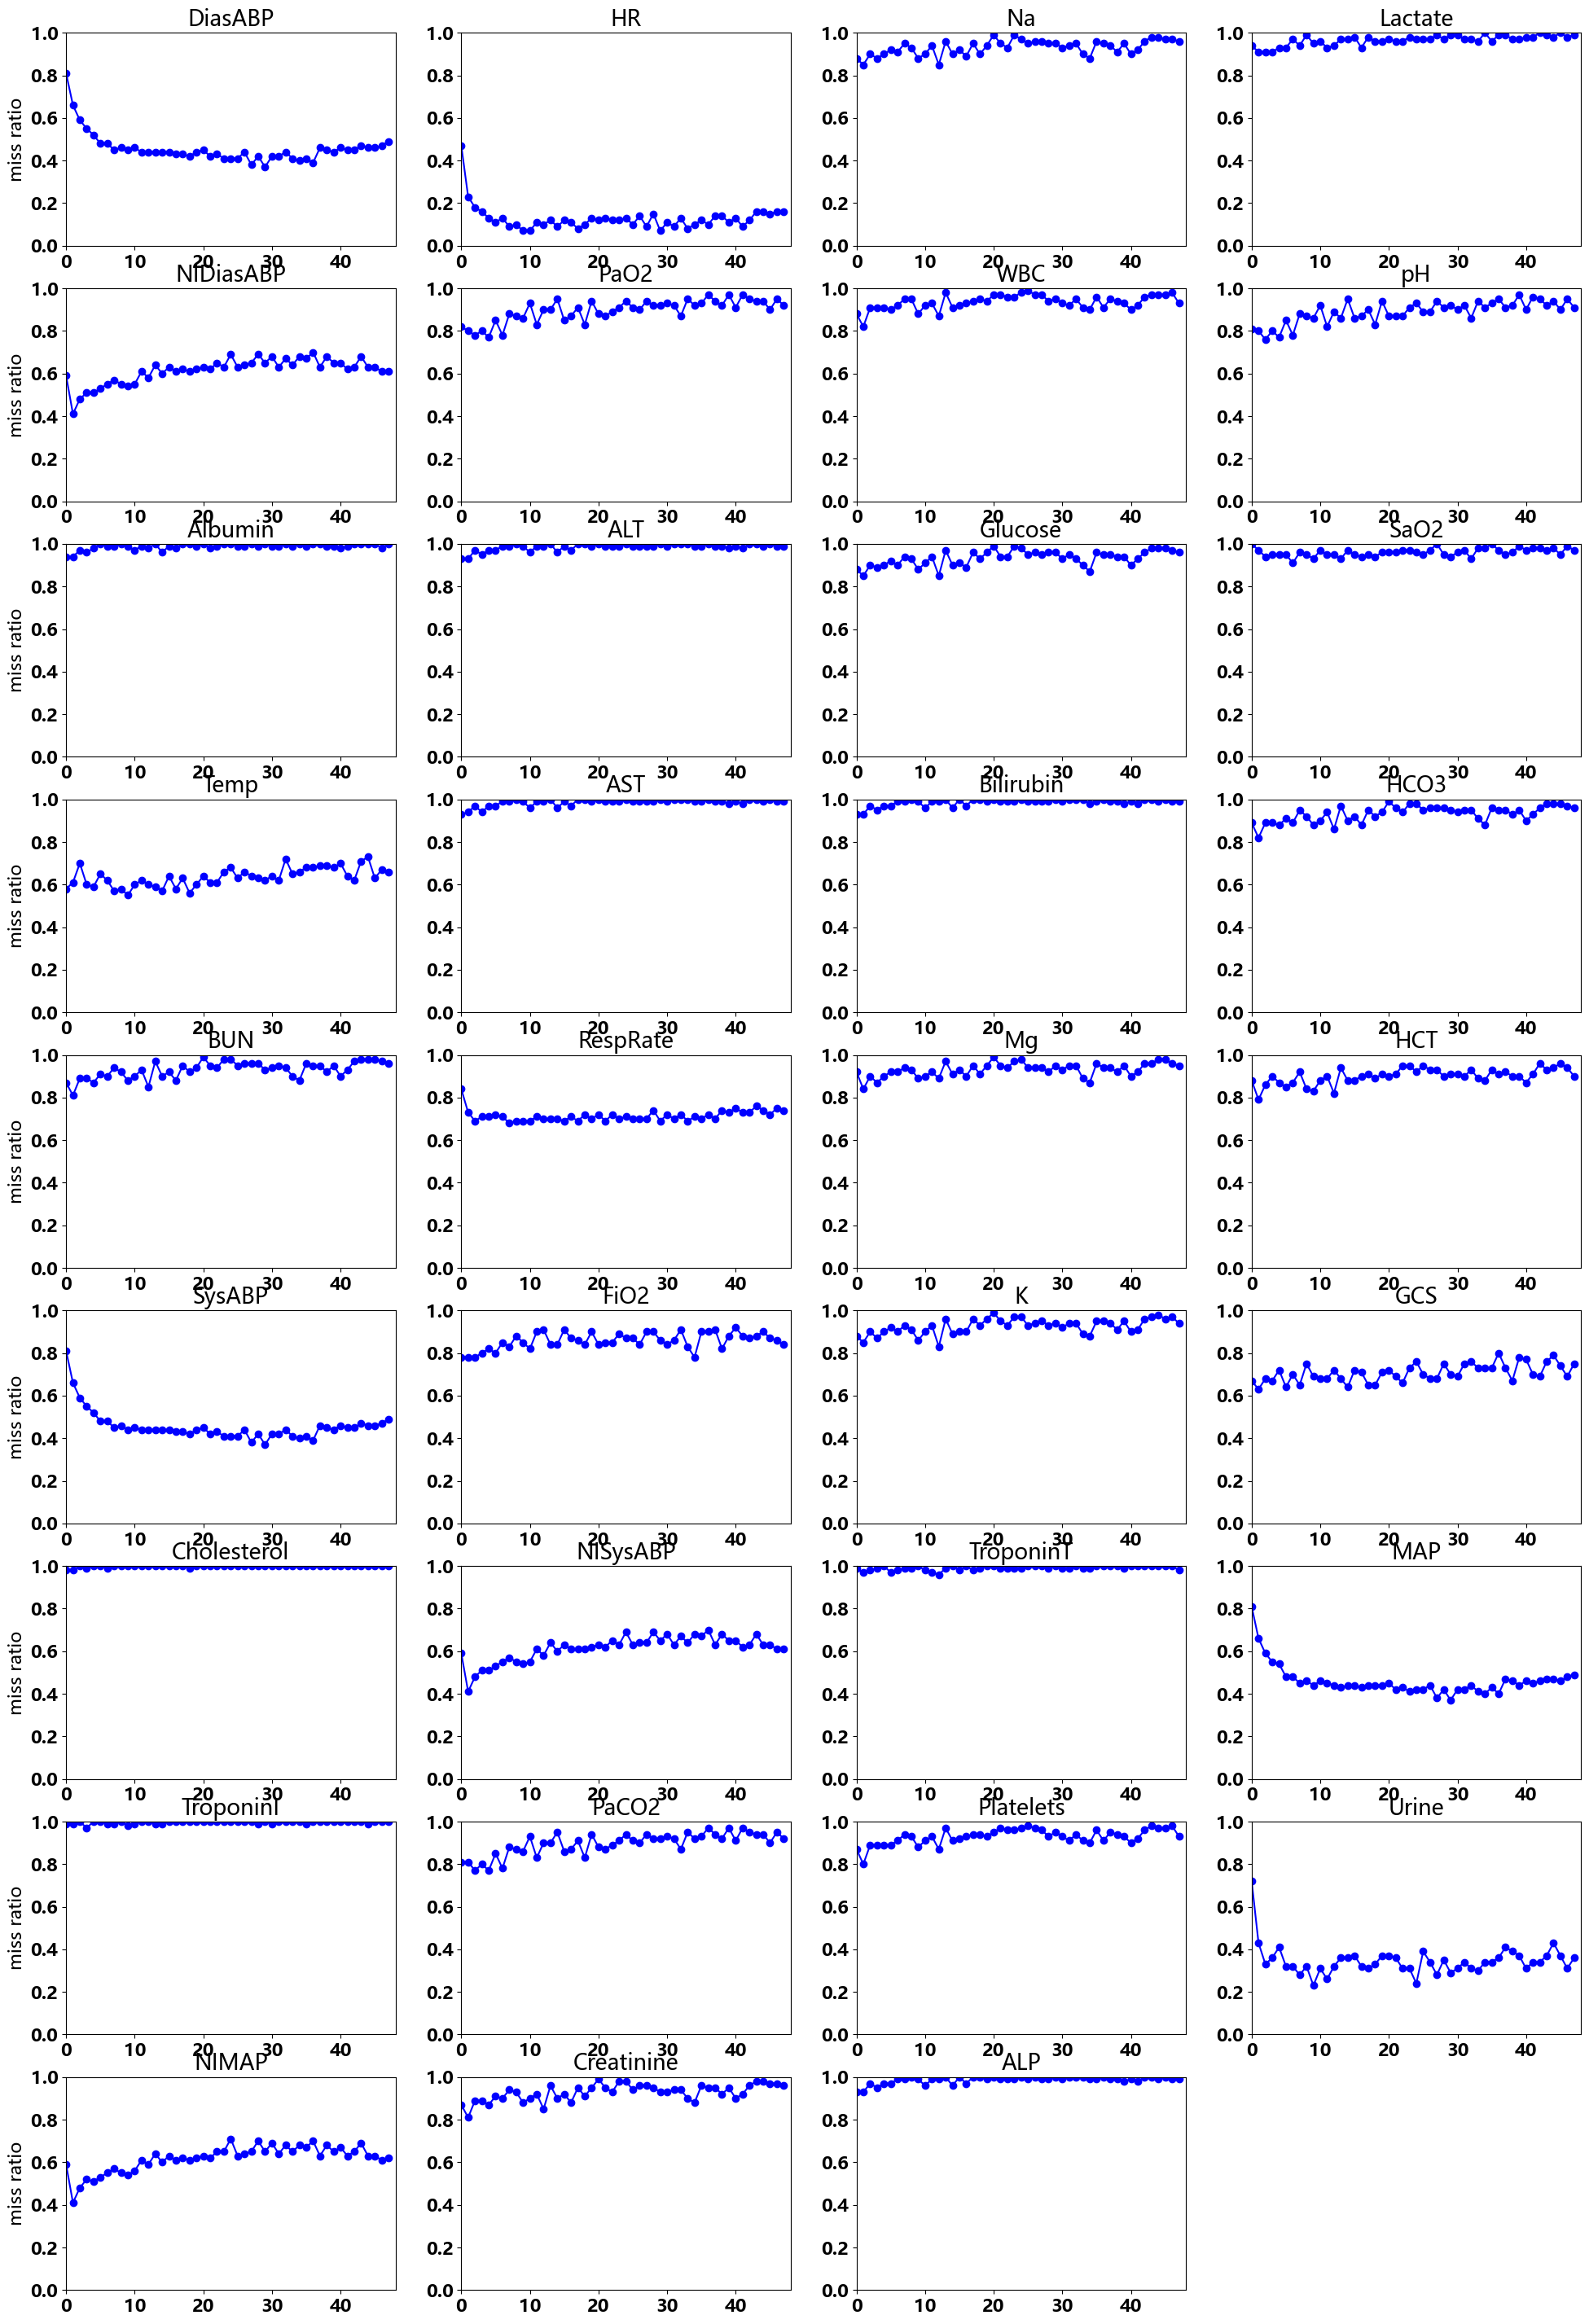

In [16]:
plt.rcParams["font.size"] = 16

fig, axes = plt.subplots(nrows=int(np.ceil(attr_count/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,attr in zip(range(attr_count),attributes):
    df=pd.DataFrame({"x":np.arange(0,hour_count),"val":df_missRatio[attr]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o')
    axes[row][col].set_xlim((0,hour_count))
    axes[row][col].set_ylim((0.0,1.0))
    axes[row][col].set_title(attr)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel='miss ratio')
    if row == hour_count//4:
        plt.setp(axes[-1, col], xlabel='hour')
#plt.suptitle("observed values in sample data")
plt.show()

## missing ratio in patient records of attributes

In [17]:
df_missRatio=df_missVal.applymap(lambda x:float(np.array(x,dtype=int).sum()/hour_count))
df_missRatio.head()

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,1.0000,0.250000,0.958333,1.0000,0.312500,1.000000,0.958333,1.000000,1.000000,1.000000,...,0.312500,1.0,1.0000,1.0,1.000000,0.958333,0.250000,0.312500,0.958333,1.000000
132540,0.0625,0.020833,0.958333,1.0000,0.750000,0.854167,0.937500,0.833333,1.000000,1.000000,...,0.750000,1.0,0.0625,1.0,0.854167,0.895833,0.208333,0.750000,0.937500,1.000000
132541,0.6875,0.020833,0.937500,0.9375,0.333333,0.916667,0.937500,0.916667,0.958333,0.958333,...,0.333333,1.0,0.6875,1.0,0.916667,0.937500,0.145833,0.333333,0.937500,0.958333
132543,1.0000,0.000000,0.937500,1.0000,0.041667,1.000000,0.937500,1.000000,0.979167,0.979167,...,0.041667,1.0,1.0000,1.0,1.000000,0.937500,0.875000,0.041667,0.937500,0.979167
132545,1.0000,0.062500,0.958333,1.0000,0.166667,1.000000,0.958333,1.000000,0.979167,1.000000,...,0.166667,1.0,1.0000,1.0,1.000000,0.958333,0.208333,0.166667,0.958333,1.000000


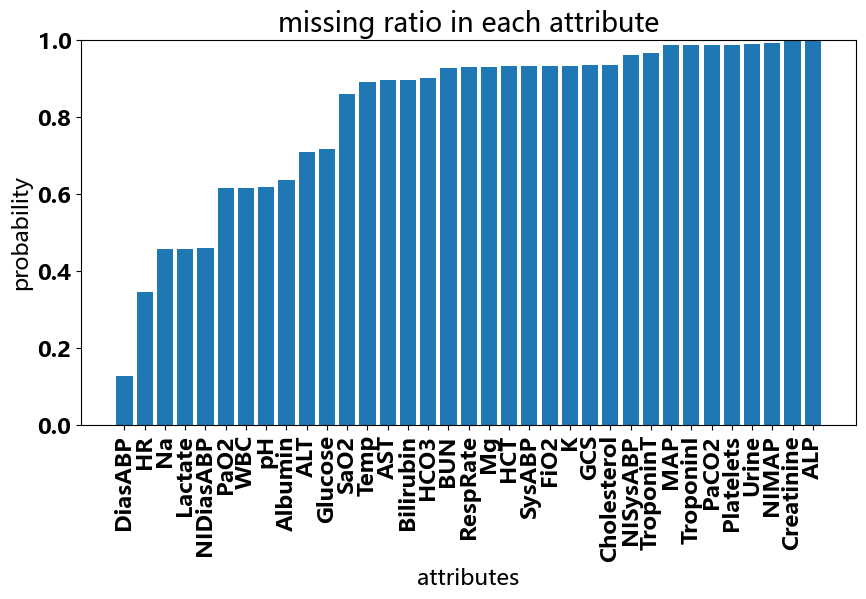

In [22]:
attr_missRatio=np.array(df_missRatio.mean(axis=0),dtype=float)
attr_missRatio.sort()
plt.figure(figsize=(10,5))

plt.bar(x=attributes,height=attr_missRatio)
plt.ylim((0,1.0))
plt.xticks(rotation=90)
plt.xlabel("attributes")
plt.ylabel("probability")
plt.title("missing ratio in each attribute")
plt.show()

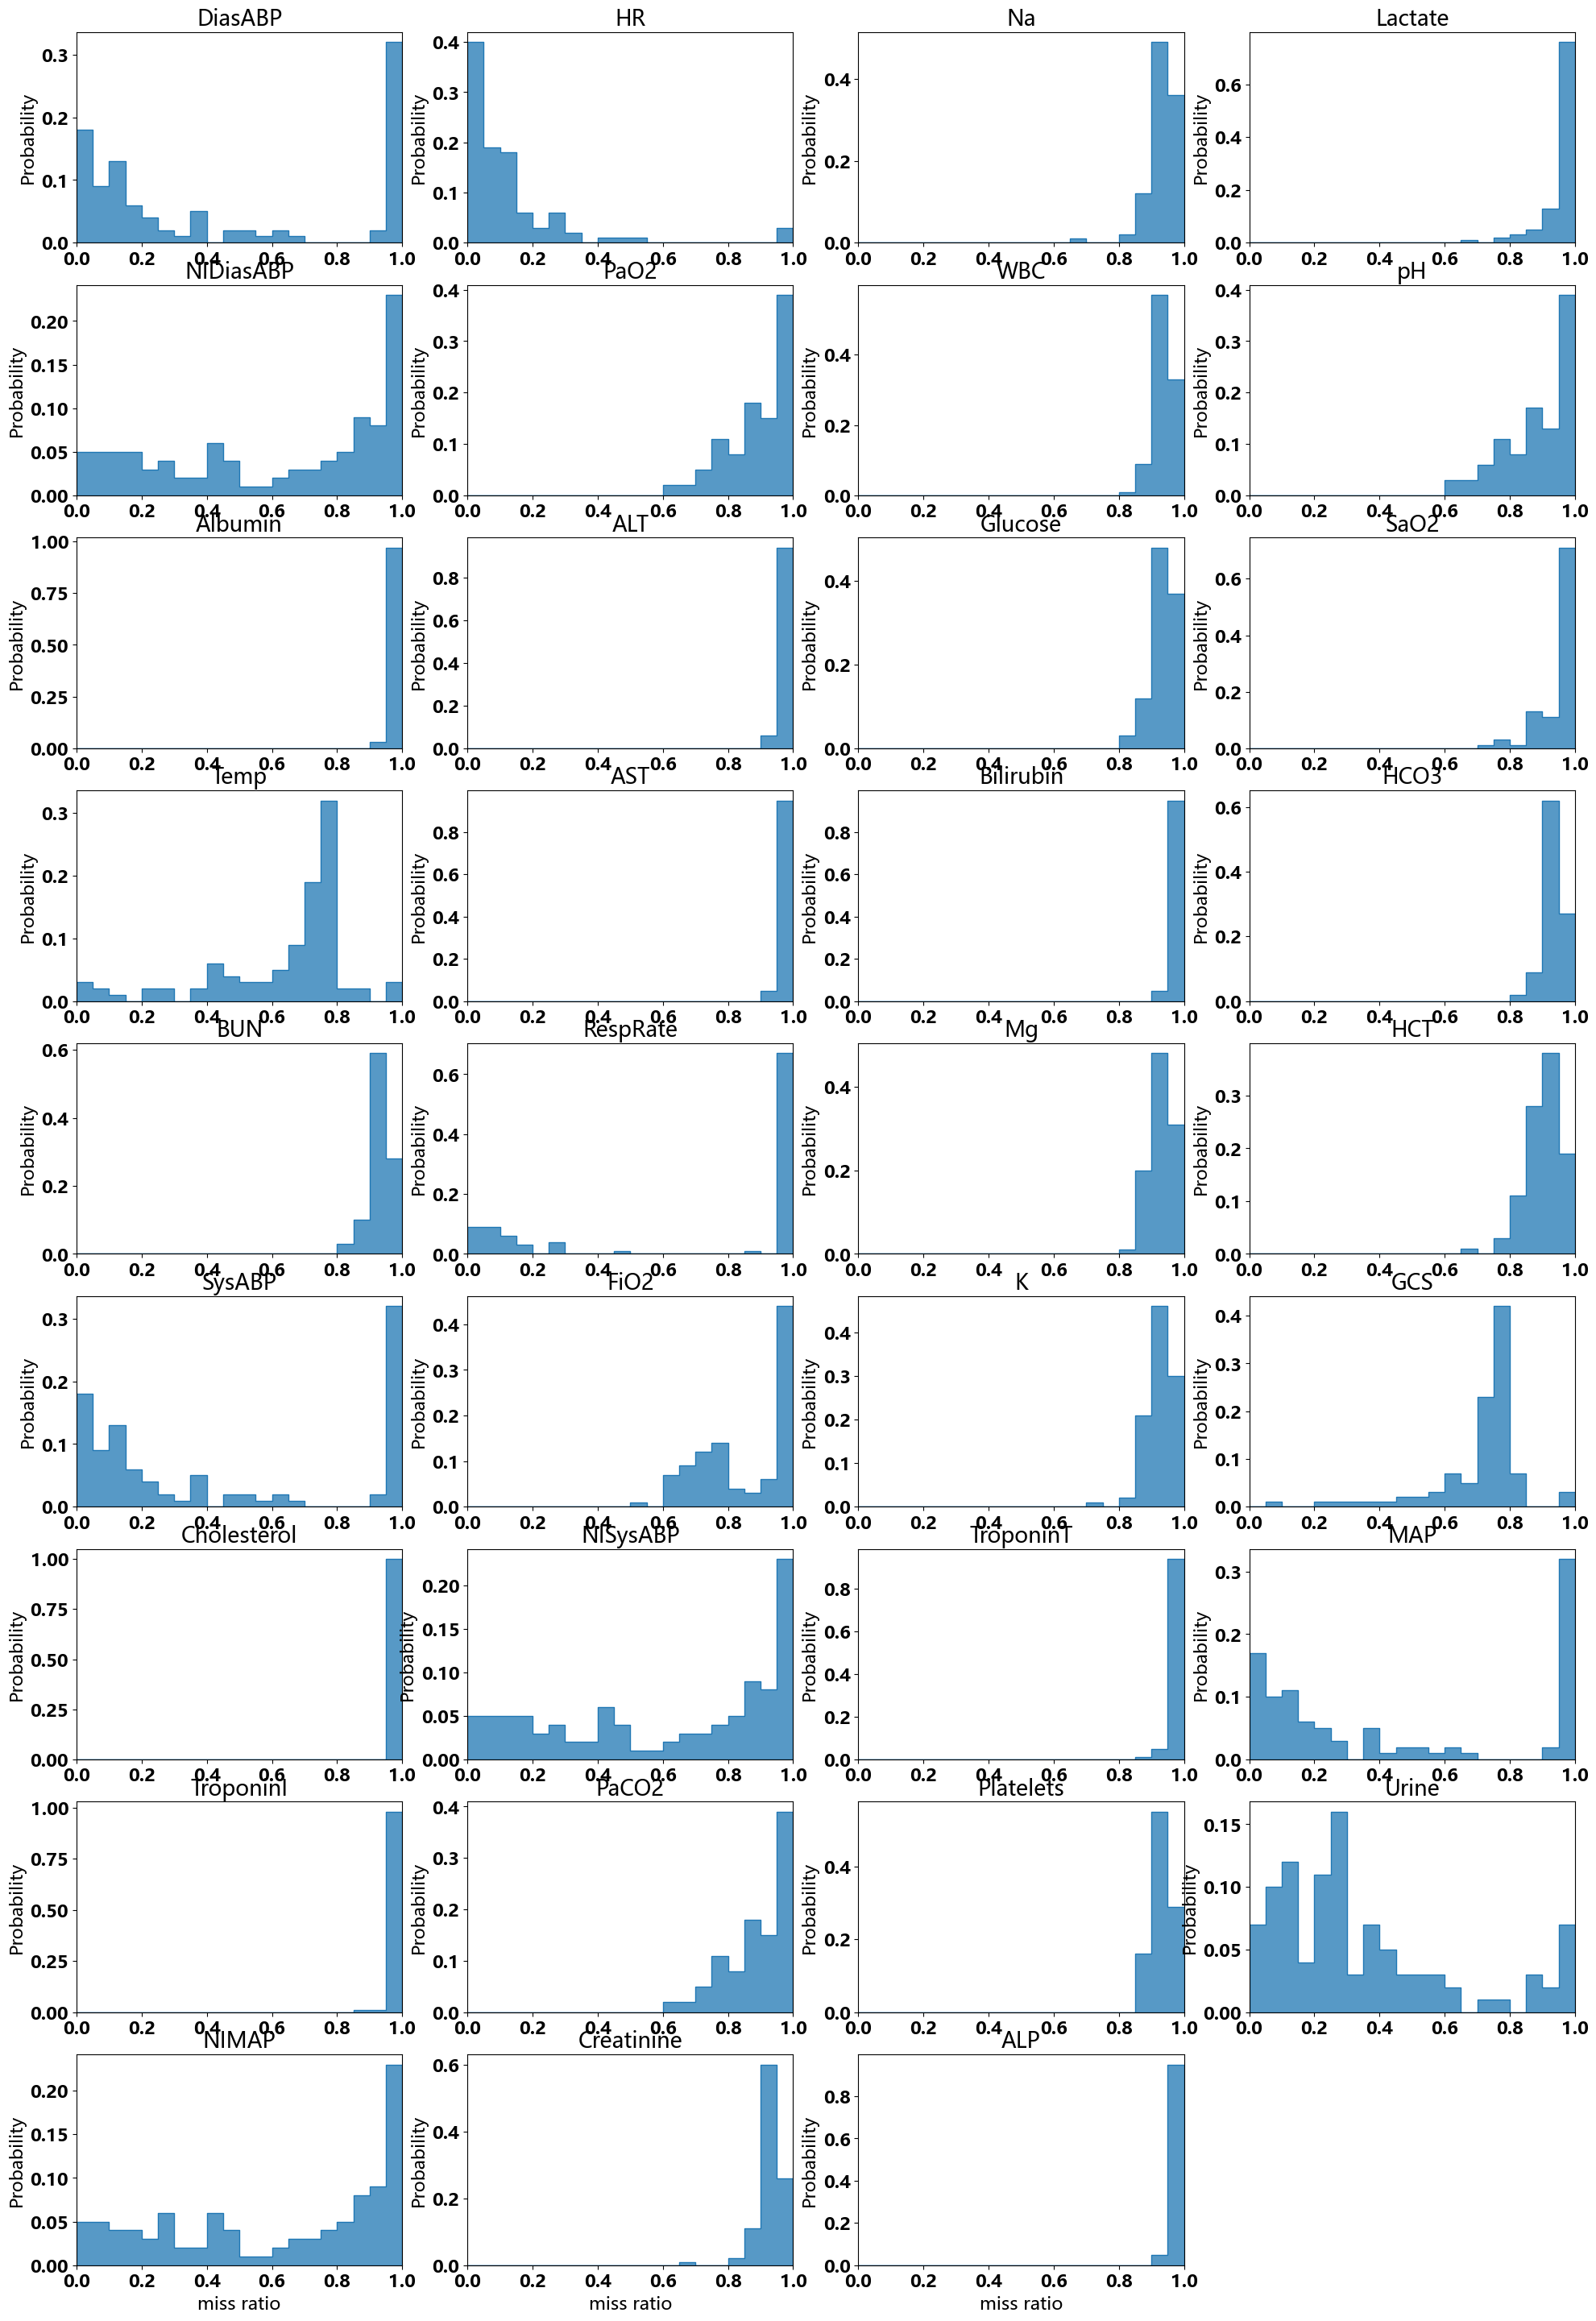

In [23]:
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=int(np.ceil(attr_count/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,attr in zip(range(0,attr_count),attributes):
    df=df_missRatio[attr]
    row = k // 4
    col = k % 4
    sns.histplot(data=df,bins=20,binrange=(0,1.0),stat="probability",element="step",ax=axes[row][col]).set(xlabel=None) #type:ignore
    axes[row][col].set_xlim((0,1.0))
    axes[row][col].set_title(attr)
    if row == attr_count//4:
        plt.setp(axes[-1, col], xlabel='miss ratio')
plt.show()

## correlations of missing pattern

In [24]:
def missVal_corr(x: np.ndarray, y: np.ndarray) -> float:
    """using Manhatten distance to represent similarity between boolean series"""
    sum_sim: float = 0
    for _x, _y in zip(x, y):
        similarity = sum(_x == _y) / hour_count
        sum_sim += similarity
    return sum_sim / len(x)


def corr(df: pd.DataFrame, method) -> pd.DataFrame:
    """
  same as: `pd.dataframe.corr()`\\
  `corr()` from `pandas` somehow failed in transfering the `method` argument,
  so we manually calculate the correlation matrix"""
    labels = df.columns.to_list()
    label_count = len(labels)
    corr_mat = np.zeros((label_count, label_count))
    for i in range(0, label_count):
        for j in range(i, label_count):
            label1 = labels[i]
            label2 = labels[j]
            corr_mat[i][j] = method(df[label1], df[label2])  # type:ignore
        for j in range(0, i):  # the lower triangle part, omitted in heatmap below
            corr_mat[i][j] = corr_mat[j][i]
    return pd.DataFrame(corr_mat, columns=attributes, index=attributes)


<AxesSubplot: >

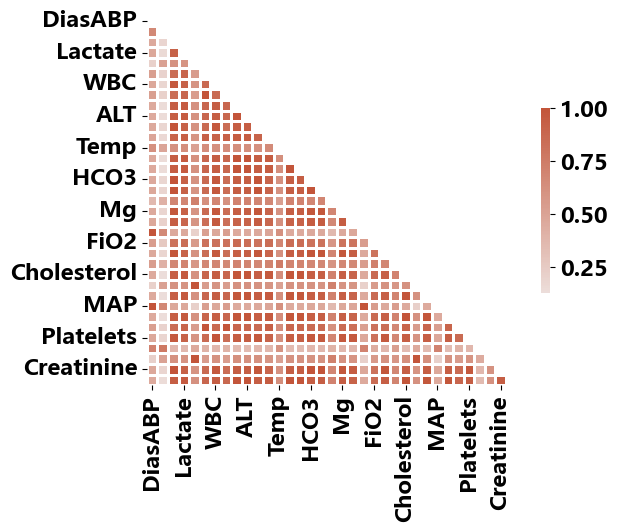

In [25]:
correlation = corr(df_missVal, missVal_corr)
mask = np.zeros_like(correlation, dtype=np.bool8)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    correlation,
    mask=mask,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.5},
    annot=False,
)


## Z-score normalization

In [26]:
"""below is Z-score normalization, same as used in demo"""
id_list=df_all.index.to_list()
df_normalize=pd.DataFrame(columns=attributes,index=id_list)
for attr in attributes:
    _values=np.array(df_all[attr].to_list()).transpose()
    mean=np.nanmean(_values,axis=1).reshape(-1,hour_count)
    std=np.nanstd(_values,axis=1).reshape(-1,hour_count)
    df_normalize[attr]=df_all[attr].map(lambda x:np.array((x-mean)/std,dtype=float)[0])
    

df_normalize.head(n=1)

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.38396131422218305, -1.3128980359905302, -1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.2879678460430408, 0.24342541295068126, -0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[1.372344683917598, 0.7501618002756244, 0.1440...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.5634300377739445, -0.7124425759462417, 0.1...","[0.6560616017984555, 0.5954505720455671, -0.08...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [27]:
target_attr="HR"
_values=np.array(df_normalize[target_attr].to_list()).transpose()
_df=pd.DataFrame(_values,columns=id_list,index=range(0,hour_count))
_df.head()
    

,132539,132540,132541,132543,132545,132547,132548,132551,132554,132555,...,132769,132772,132773,132774,132776,132777,132780,132781,132783,132786
0,-0.383961,NaN,-0.323033,-0.566745,NaN,NaN,-0.627673,1.261094,NaN,-0.993241,...,1.017383,1.992230,NaN,NaN,1.870374,0.347175,-0.079321,-0.749529,-0.688601,NaN
1,-1.312898,0.206484,0.640593,-0.064834,NaN,NaN,-1.095844,0.369275,NaN,-0.444680,...,0.694856,1.400284,-0.010571,0.043693,1.291756,-0.336153,-0.227625,-0.498944,-0.607471,NaN
2,-1.026028,0.350619,1.091891,-0.443601,0.138827,NaN,-0.602445,NaN,NaN,-0.496549,...,1.197786,0.880099,0.297671,-0.761289,1.674318,-0.549497,-0.337705,-0.284757,-0.337705,NaN
3,-0.119335,0.323720,0.212956,-0.507008,0.656011,NaN,-0.507008,NaN,2.483613,-0.617771,...,NaN,0.988302,0.268338,-0.562390,1.929794,-0.839299,-0.174717,-0.285480,-0.507008,NaN
4,-0.459915,0.311678,0.256564,-0.459915,0.256564,-0.23946,NaN,NaN,2.461117,-0.184346,...,0.752589,0.697475,0.091223,0.256564,1.634410,-0.900826,-0.294574,-0.790598,-0.515029,NaN


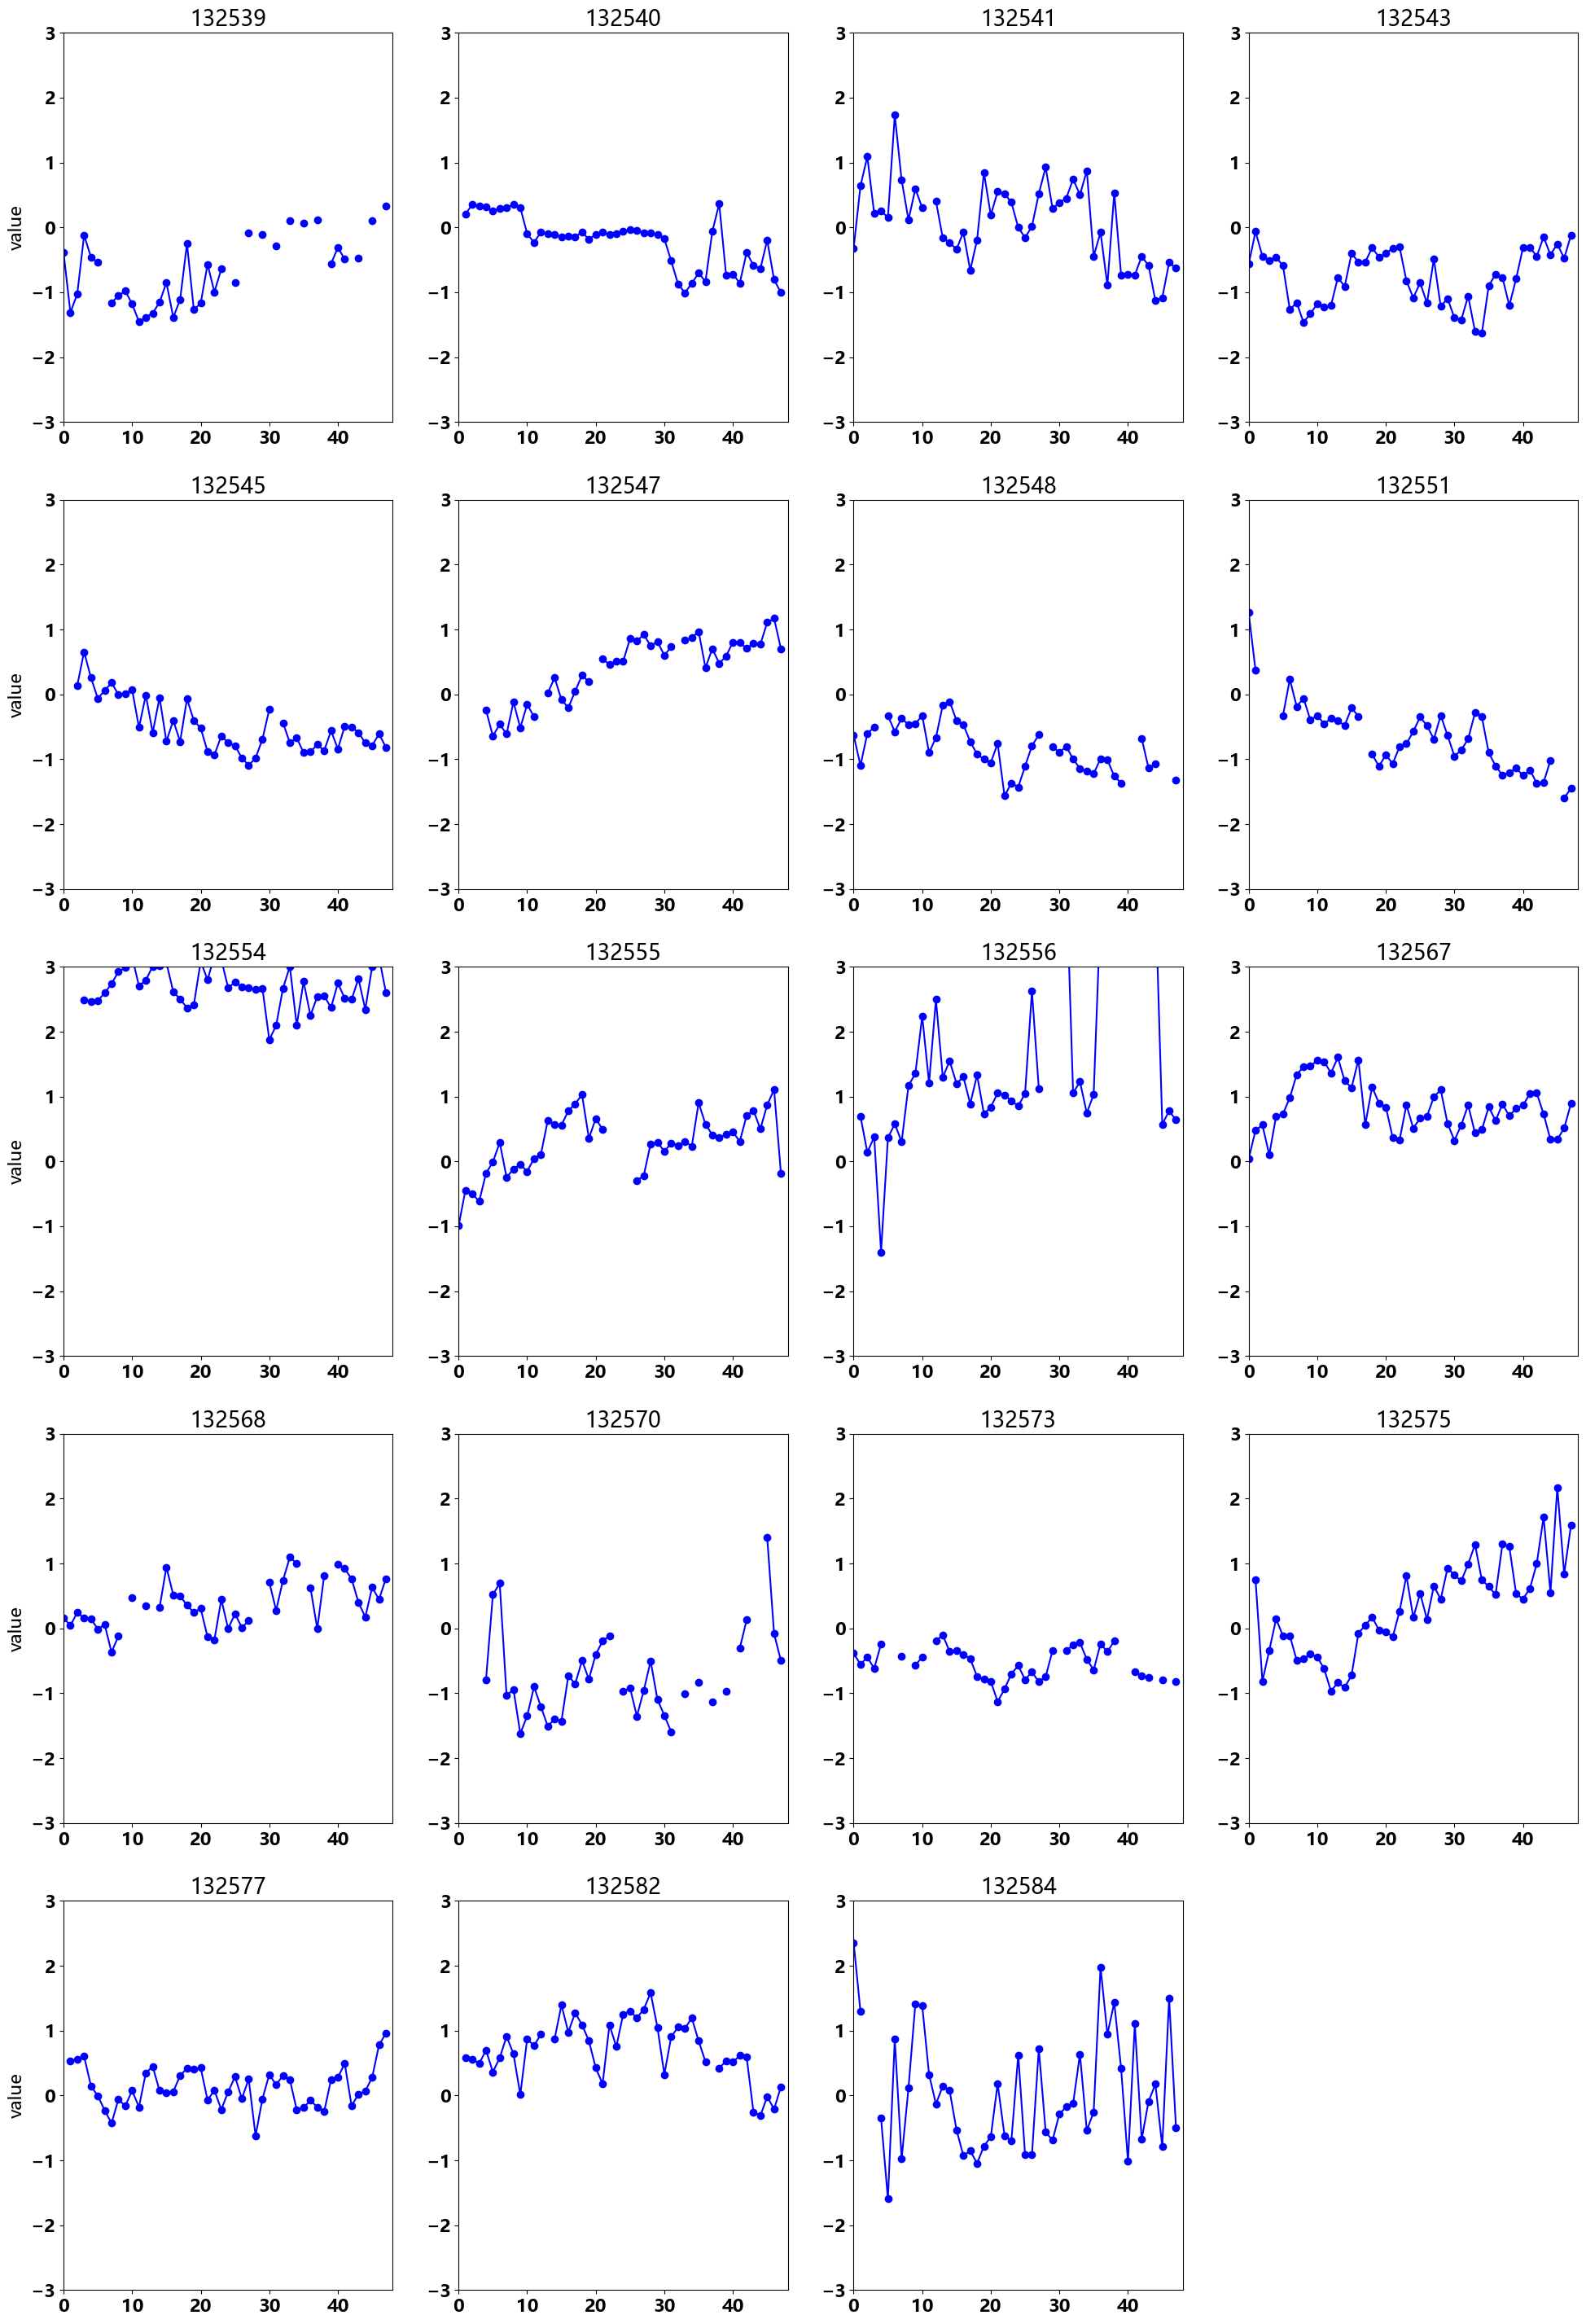

In [28]:
plt.rcParams["font.size"] = 16

fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

id_list=id_list[0:20]
for k,_id in zip(range(0,20),id_list):
    df=pd.DataFrame({"x":np.arange(0,hour_count),"val":_df[_id]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='-')
    axes[row][col].set_xlim((0,hour_count))
    axes[row][col].set_ylim((-3,3))
    axes[row][col].set_title(_id)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == hour_count//4:
        plt.setp(axes[-1, col], xlabel='hour')
plt.show()

## correlation between attributes

In [29]:
df_fillNaN=df_normalize.applymap(lambda x:np.nan_to_num(x))
df_fillNaN.head(n=1)


,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.38396131422218305, -1.3128980359905302, -1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2879678460430408, 0.24342541295068126, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[1.372344683917598, 0.7501618002756244, 0.1440...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5634300377739445, -0.7124425759462417, 0.1...","[0.6560616017984555, 0.5954505720455671, -0.08...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
from scipy.signal import correlate as ndcorr

def timeSeries_corr(x:pd.Series,y:pd.Series)->float:
      """correlation between two time series"""
      _x=np.array(x.to_list()).transpose()
      _y=np.array(y.to_list()).transpose()
      similarity=ndcorr(_x,_y,mode="valid",method="fft")[0][0]
      return similarity/len(x)

<AxesSubplot: >

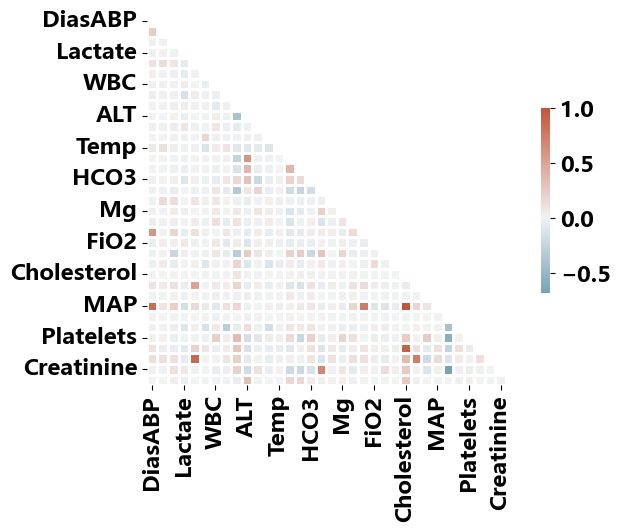

In [31]:
correlation=corr(df_fillNaN,timeSeries_corr)
attr_self_corr=np.diag(np.array(correlation)) 
for k,attr in zip(range(0,attr_count),correlation.columns):
    correlation[attr]=correlation[attr]/attr_self_corr[k]
    
mask = np.zeros_like(correlation, dtype=np.bool8)   
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask[np.triu_indices_from(mask)]= True      
sns.heatmap(correlation
            ,mask=mask       
            ,cmap=cmap
           , vmax=1
            , center=0
            ,square=True
            , linewidths=1
            , cbar_kws={"shrink": .5}
            , annot=False     
           )